# Credit Card Fraud Feature Engineering, Regression, and Deep Learning

Code and analysis by Luke Theivagt


The data used for this project was collected from a fake transaction data generator.
https://github.com/namebrandon/Sparkov_Data_Generation/tree/master


In [ ]:
!pip install category_encoders
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 1.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTENC

import category_encoders as ce

from collections import Counter

from xgboost import XGBClassifier


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data Analysis Projects/fraudTrain.csv')

In [ ]:
CCData = data

# EDA

In [ ]:
CCData.tail()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0
1296674,1296674,2020-06-21 12:13:37,4292902571056973207,"fraud_Langosh, Wintheiser and Hyatt",food_dining,4.30,Jeffrey,Smith,M,135 Joseph Mountains,...,45.8433,-113.8748,218,"Therapist, horticultural",1995-08-16,8f7c8e4ab7f25875d753b422917c98c9,1371816817,46.565983,-114.186110,0


In [ ]:
CCData.shape

(1296675, 23)

In [ ]:
CCData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [ ]:
CCData['is_fraud'].value_counts()
Percent_Fraud = round((CCData['is_fraud'].value_counts()[1]/CCData.shape[0] *100),2)
print(Percent_Fraud, "% of transactions are fraudulent")

0.58 % of transactions are fraudulent


Oversampling and Undersampling techniques will be nessicairy as the fradulent cases take up such a small part of the total dataset.

In [ ]:
CCData['category'].value_counts()

,count
category,
gas_transport,131659
grocery_pos,123638
home,123115
shopping_pos,116672
kids_pets,113035
shopping_net,97543
entertainment,94014
food_dining,91461
personal_care,90758


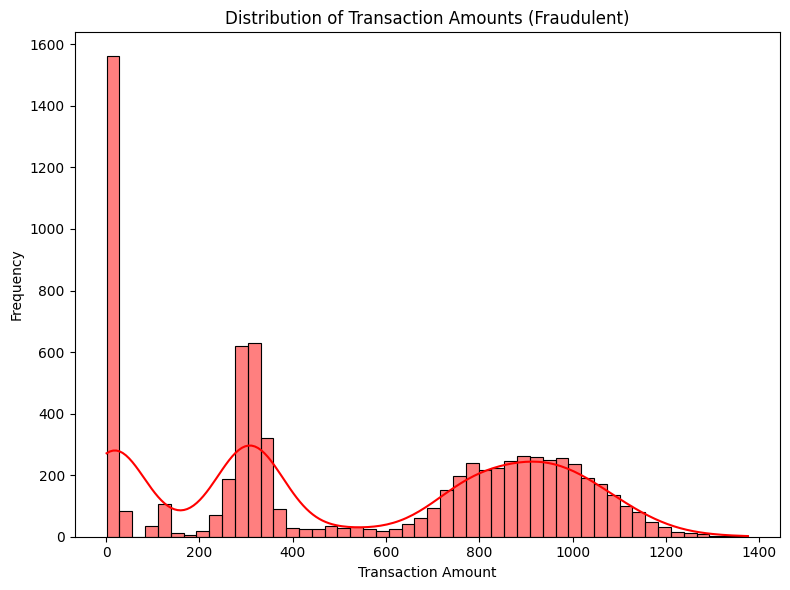

In [ ]:

fraud_data = CCData[CCData['is_fraud'] == 1]

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(fraud_data['amt'], bins=50, kde=True, ax=ax, color='red')
ax.set_title('Distribution of Transaction Amounts (Fraudulent)')
ax.set_xlabel('Transaction Amount')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

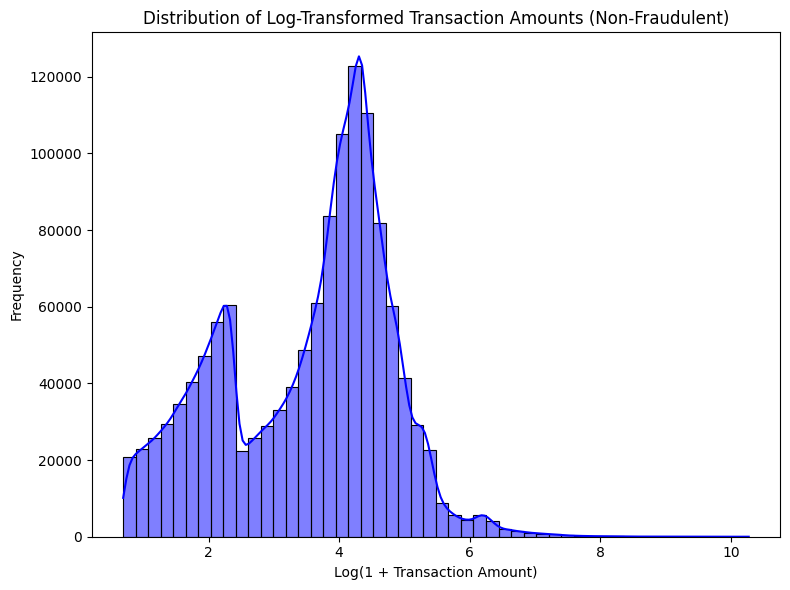

In [ ]:
non_fraud_data = CCData[CCData['is_fraud'] == 0]

fig, ax = plt.subplots(figsize=(8, 6))
# Apply a logarithmic transformation to 'amt' to better visualize the distribution
sns.histplot(np.log1p(non_fraud_data['amt']), bins=50, kde=True, ax=ax, color='blue')
ax.set_title('Distribution of Log-Transformed Transaction Amounts (Non-Fraudulent)')
ax.set_xlabel('Log(1 + Transaction Amount)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

There was a large frequency of 1$ transactions, making it impossible to visualize the full distribution of transactions. Therefore I applied a logarithmic transformation to more effectively visualize the distribution.

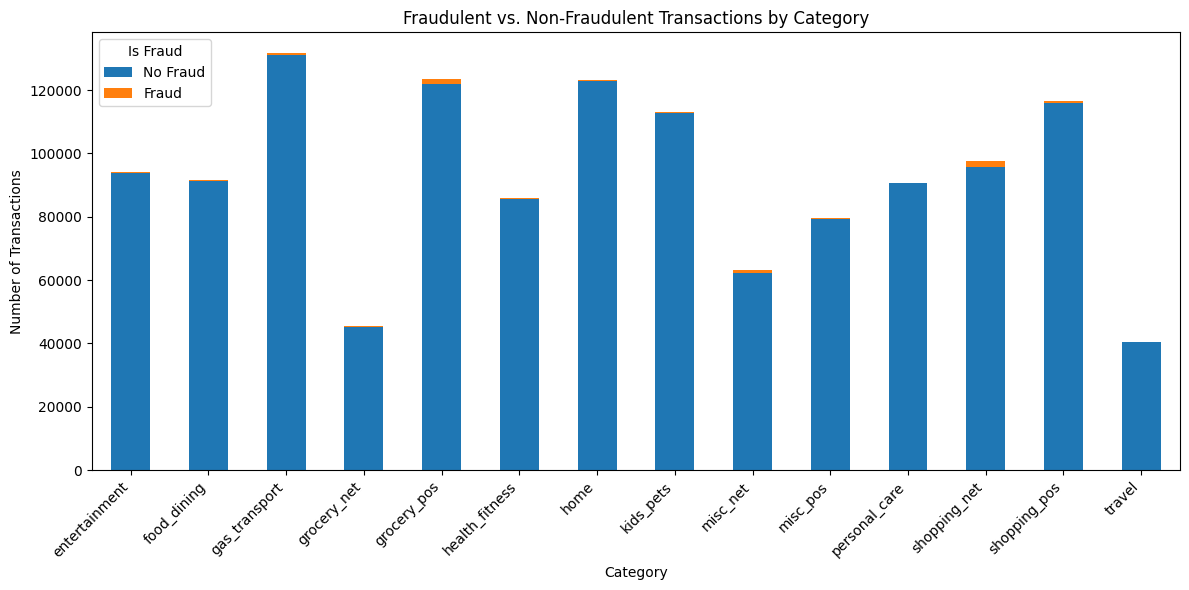

In [ ]:
category_fraud_counts = CCData.groupby(['category', 'is_fraud']).size().unstack(fill_value=0)

category_fraud_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Fraudulent vs. Non-Fraudulent Transactions by Category')
plt.xlabel('Category')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Is Fraud', labels=['No Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

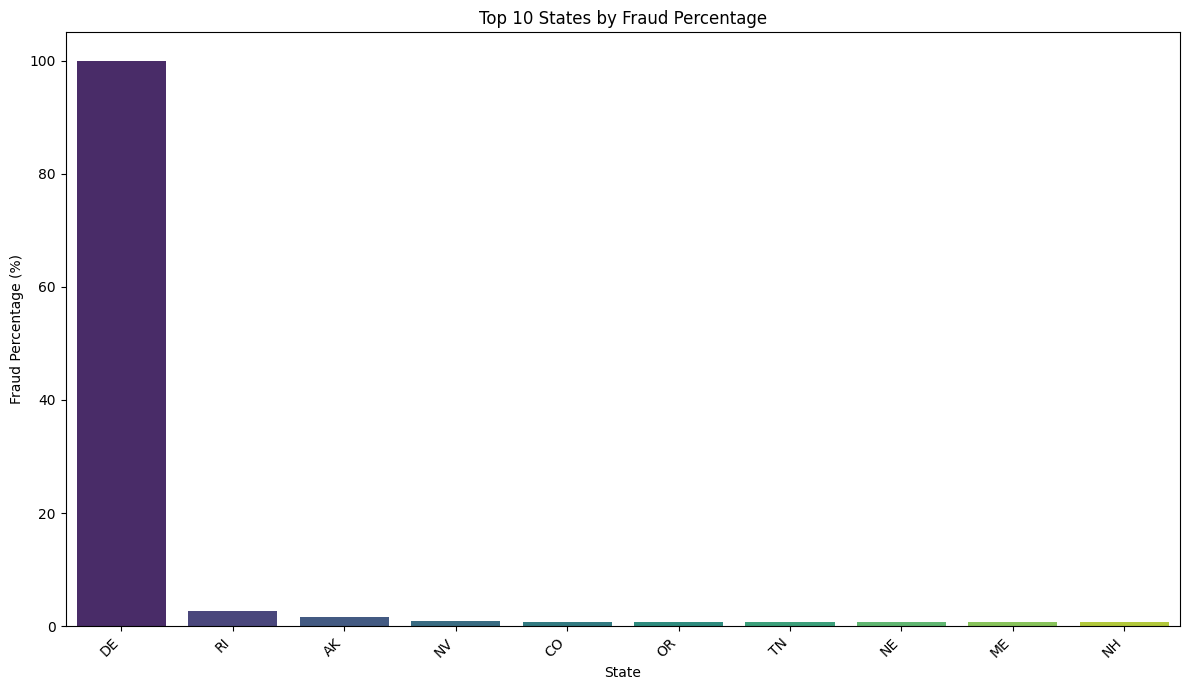

is_fraud,0,1,Total,Fraud_Percentage
state,,,,
DE,0,9,9,100.000000
RI,535,15,550,2.727273
AK,2084,36,2120,1.698113
NV,5560,47,5607,0.838238
CO,13767,113,13880,0.814121
OR,18448,149,18597,0.801204
TN,17414,140,17554,0.797539
NE,23988,180,24168,0.744786
ME,16386,119,16505,0.720994


In [ ]:
state_fraud_counts = data.groupby(['state', 'is_fraud']).size().unstack(fill_value=0)
state_fraud_counts['Total'] = state_fraud_counts[0] + state_fraud_counts[1]

# Avoid division by zero if a state has no transactions
state_fraud_counts['Fraud_Percentage'] = (state_fraud_counts[1] / state_fraud_counts['Total']) * 100
top_10_fraud_states = state_fraud_counts.sort_values(by='Fraud_Percentage', ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_10_fraud_states.index, y=top_10_fraud_states['Fraud_Percentage'],
            hue = top_10_fraud_states.index, palette='viridis', legend = False)
plt.title('Top 10 States by Fraud Percentage')
plt.xlabel('State')
plt.ylabel('Fraud Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

display(top_10_fraud_states)

In [ ]:
category_fraud_counts = CCData.groupby(['category', 'is_fraud']).size().unstack(fill_value=0)
category_fraud_counts['Total'] = category_fraud_counts[0] + category_fraud_counts[1]
category_fraud_counts['Fraud_Percentage'] = (category_fraud_counts[1] / category_fraud_counts['Total']) * 100

top_5_fraud_categories = category_fraud_counts.sort_values(by='Fraud_Percentage', ascending=False).head(5)
display(top_5_fraud_categories)

is_fraud,0,1,Total,Fraud_Percentage
category,,,,
shopping_net,95830,1713,97543,1.756149
misc_net,62372,915,63287,1.445795
grocery_pos,121895,1743,123638,1.409761
shopping_pos,115829,843,116672,0.722538
gas_transport,131041,618,131659,0.469394


The shopping_net category sees the highest percentage of fraud.

In [ ]:
city_fraud_counts = data.groupby(['city', 'is_fraud']).size().unstack(fill_value=0)
city_fraud_counts['Total'] = city_fraud_counts[0] + city_fraud_counts[1]

city_fraud_counts['Fraud_Percentage'] = (city_fraud_counts[1] / city_fraud_counts['Total']) * 100
top_10_fraud_cities = city_fraud_counts.sort_values(by='Fraud_Percentage', ascending=False).head(10)

display(top_10_fraud_cities)

is_fraud,0,1,Total,Fraud_Percentage
city,,,,
Irvington,0,8,8,100.0
Isanti,0,10,10,100.0
La Grande,0,12,12,100.0
Wartburg,0,11,11,100.0
Vacaville,0,7,7,100.0
Waukau,0,10,10,100.0
Angwin,0,10,10,100.0
Hubbell,0,19,19,100.0
Lockhart,0,9,9,100.0


There are many cities that see 100% fraud, meaning it will likely be a useful metric for detetermining and fradulent transaction.

In [ ]:
zip_fraud_counts = data.groupby(['zip', 'is_fraud']).size().unstack(fill_value=0)
zip_fraud_counts['Total'] = zip_fraud_counts[0] + zip_fraud_counts[1]

zip_fraud_counts['Fraud_Percentage'] = (zip_fraud_counts[1] / zip_fraud_counts['Total']) * 100
top_10_fraud_zip = zip_fraud_counts.sort_values(by='Fraud_Percentage', ascending=False).head(10)

display(top_10_fraud_zip)

is_fraud,0,1,Total,Fraud_Percentage
zip,,,,
97850,0,12,12,100.0
4032,0,9,9,100.0
28033,0,8,8,100.0
27051,0,11,11,100.0
48436,0,8,8,100.0
94508,0,10,10,100.0
93427,0,8,8,100.0
90240,0,10,10,100.0
89109,0,8,8,100.0


In [ ]:
CCData['category'] = CCData['category'].astype('category')
CCData['job'] = CCData['job'].astype('category')
CCData['zip'] = CCData['zip'].astype('category')
CCData['city'] = CCData['city'].astype('category')
CCData['state'] = CCData['state'].astype('category')

# Feature Engineering: Creating Features and Encoding Categories

Date time is converted to specific categories and various categories are converted preserve magnitute of the relationship, increase dimensionality, and remove any simulated ordinal relationship. Zip code, job, and category will be binary encoded to save memory usage.

Waking hours are set from 6:00 a.m. to midnight. People have many various schedules, but I feel like most people do not often make purchaces outside of this time.

In [ ]:
# Converting date time into more specific categories

CCData['trans_date_trans_time'] = pd.to_datetime(CCData['trans_date_trans_time']) # Convert to datetime first

CCData['trans_hour'] = CCData['trans_date_trans_time'].dt.hour
CCData['trans_dayofweek'] = CCData['trans_date_trans_time'].dt.dayofweek
CCData['trans_month'] = CCData['trans_date_trans_time'].dt.month


# 0 if 12:00 to 6:00; 1 otherwise
CCData['trans_waking_hour'] = CCData['trans_hour'].apply(lambda x: 0 if 0 <= x <= 6 else 1)

if 'trans_dayofweek' in CCData.columns:
    day_of_week_encoded = pd.get_dummies(CCData['trans_dayofweek'], prefix='dayofweek', drop_first=True)
    CCData = pd.concat([CCData, day_of_week_encoded], axis=1)
    CCData = CCData.drop('trans_dayofweek', axis=1)

if 'gender' in CCData.columns:
    gender_encoded = pd.get_dummies(CCData['gender'], prefix='gender', drop_first=True)
    CCData = pd.concat([CCData, gender_encoded], axis=1)

if 'week_day' in CCData.columns:
    CCData = CCData.drop('week_day', axis=1)

Binary encoding zip, category, job, city, and state.

In [ ]:
CCData['Zip_Code'] = LabelEncoder().fit_transform(CCData['zip'])
CCData['Zip_Code'] = CCData['Zip_Code'].apply(lambda x: format(x, 'b'))
CCData['Zip_Code'] = CCData['Zip_Code'].apply(lambda x: [int(i) for i in x])

max_len = CCData['Zip_Code'].apply(len).max()
zipcode_columns = [f'Zip_Code_{i}' for i in range(max_len)]
CCData[zipcode_columns] = pd.DataFrame(CCData['Zip_Code'].tolist(), index=CCData.index)

#binary encoding merchant category
CCData['Merchant_category'] = LabelEncoder().fit_transform(CCData['category'])
CCData['Merchant_category'] = CCData['Merchant_category'].apply(lambda x: format(x, 'b'))
CCData['Merchant_category'] = CCData['Merchant_category'].apply(lambda x: [int(i) for i in x])

max_len = CCData['Merchant_category'].apply(len).max()
category_columns = [f'Merchant_category{i}' for i in range(max_len)]
CCData[category_columns] = pd.DataFrame(CCData['Merchant_category'].tolist(), index=CCData.index)

#Binary encoding cardholder job
CCData['Cardholder_Job'] = LabelEncoder().fit_transform(CCData['job'])
CCData['Cardholder_Job'] = CCData['Cardholder_Job'].apply(lambda x: format(x, 'b'))
CCData['Cardholder_Job'] = CCData['Cardholder_Job'].apply(lambda x: [int(i) for i in x])

#Binary encoding city
CCData['City'] = LabelEncoder().fit_transform(CCData['city'])
CCData['City'] = CCData['City'].apply(lambda x: format(x, 'b'))
CCData['City'] = CCData['City'].apply(lambda x: [int(i) for i in x])

max_len = CCData['City'].apply(len).max()
zipcode_columns = [f'City_{i}' for i in range(max_len)]
CCData[zipcode_columns] = pd.DataFrame(CCData['City'].tolist(), index=CCData.index)

#Binary encoding month
CCData['trans_month'] = LabelEncoder().fit_transform(CCData['trans_month'])
CCData['trans_month'] = CCData['trans_month'].apply(lambda x: format(x, 'b'))
CCData['trans_month'] = CCData['trans_month'].apply(lambda x: [int(i) for i in x])

Creating Feature for customer age.

In [ ]:
#Use DOB to create a category for cardholder age
CCData['DOB'] = pd.to_datetime(CCData['dob'])
CCData['Cardholder_Age'] = CCData['trans_date_trans_time'].dt.year - CCData['DOB'].dt.year
CCData = CCData.drop('DOB', axis=1)

Feature for distance between transaction and billing address.

In [ ]:
def haversine_distance(row):
    """
    Calculates the Haversine distance (in kilometers) between two sets of
    latitude and longitude points.
    """
    R = 6371
    lat1_rad = np.radians(row['lat'])
    lon1_rad = np.radians(row['long'])
    lat2_rad = np.radians(row['merch_lat'])
    lon2_rad = np.radians(row['merch_long'])

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

CCData['distance_km'] = CCData.apply(haversine_distance, axis=1)


In [ ]:
CCData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 59 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0             1296675 non-null  int64         
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   cc_num                 1296675 non-null  int64         
 3   merchant               1296675 non-null  object        
 4   category               1296675 non-null  category      
 5   amt                    1296675 non-null  float64       
 6   first                  1296675 non-null  object        
 7   last                   1296675 non-null  object        
 8   street                 1296675 non-null  object        
 9   city                   1296675 non-null  category      
 10  state                  1296675 non-null  object        
 11  zip                    1296675 non-null  category      
 12  lat                    12966

Feature for the z score of purchase ammount per credit card.

In [ ]:
df = CCData.sort_values(['cc_num', 'trans_date_trans_time']).reset_index(drop=True)

df['user_avg_amount'] = df.groupby('cc_num')['amt'].transform('mean')
df['user_std_amount'] = df.groupby('cc_num')['amt'].transform('std')

df['user_std_amount'] = df['user_std_amount'].fillna(0)

CCData['amount_zscore'] = (df['amt'] - df['user_avg_amount']) / df['user_std_amount'].replace(0, 1)

# Regression Model


In [ ]:
y = CCData["is_fraud"]
columns_to_keep = [
    'amt', 'distance_km', 'city_pop', 'trans_hour',
    'trans_waking_hour', 'Cardholder_Age', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6',
    'gender_M', 'amount_zscore', 'Zip_Code_2','Zip_Code_3','Zip_Code_5','Zip_Code_6',
    'Zip_Code_7','Zip_Code_8','Zip_Code_9', 'Merchant_category0','Merchant_category1','Merchant_category2',
    'Merchant_category3', 'City_0', 'City_1','City_2','City_3','City_4','City_5','City_6','City_7','City_8','City_9']
X = CCData[columns_to_keep]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

y_train_aligned = y_train.reset_index(drop=True)
y_test_aligned = y_test.reset_index(drop=True)

X_train_final = sm.add_constant(X_train_scaled, prepend=False)
X_test_final = sm.add_constant(X_test_scaled, prepend=False)

In [ ]:
logit_mod = sm.Logit(y_train_aligned, X_train_final)
logit_res = logit_mod.fit_regularized(alpha=1e-4, L1_wt=0) # L1_wt=0 so L2 (ridge) regularization

print(logit_res.summary())

y_pred_prob = logit_res.predict(X_test_final)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.029153504635442435
            Iterations: 127
            Function evaluations: 131
            Gradient evaluations: 127


/usr/local/lib/python3.12/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 36 out of 36 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:               is_fraud   No. Observations:              1037340
Model:                          Logit   Df Residuals:                  1037304
Method:                           MLE   Df Model:                           35
Date:                Mon, 24 Nov 2025   Pseudo R-squ.:                  0.1795
Time:                        21:26:37   Log-Likelihood:                -30242.
converged:                       True   LL-Null:                       -36857.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
amt                    0.4448      0.006     79.892      0.000       0.434       0.456
distance_km            0.0091      0.014      0.669      0.503      -0.018       0.036
city_pop            

The model shows that higher transaction amounts and certain transaction times are strong predictors of fraud. Transactions during waking hours are much less likely to be fraudulent, while specific hours and mid-week days slightly increase risk. A few location variables and cardholder age have small but significant effects.

# Sampling Techniques

In [ ]:
dfcolumns_to_keep = [
    'amt', 'distance_km', 'city_pop', 'trans_hour', 'gender', 'category',
    'trans_waking_hour', 'Cardholder_Age', 'amount_zscore','zip', 'merchant','state', 'city']
X = CCData[dfcolumns_to_keep]
y = df['is_fraud']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   amt                1296675 non-null  float64 
 1   distance_km        1296675 non-null  float64 
 2   city_pop           1296675 non-null  int64   
 3   trans_hour         1296675 non-null  int32   
 4   gender             1296675 non-null  object  
 5   category           1296675 non-null  category
 6   trans_waking_hour  1296675 non-null  int64   
 7   Cardholder_Age     1296675 non-null  int32   
 8   amount_zscore      1296675 non-null  float64 
 9   zip                1296675 non-null  category
 10  merchant           1296675 non-null  object  
 11  state              1296675 non-null  category
 12  city               1296675 non-null  category
dtypes: category(4), float64(3), int32(2), int64(2), object(2)
memory usage: 86.6+ MB


Spliting features and seperating into training and testing.

In [ ]:
HIGH_CARDINALITY_COLS = ['zip', 'merchant','state', 'city']
OTHER_CATEGORICAL_COLS = ['category', 'gender', 'trans_waking_hour']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

Target encoding for high-cardinality features

In [ ]:
target_encoder = ce.TargetEncoder(
    cols=HIGH_CARDINALITY_COLS,
    smoothing=0.2)

target_encoder.fit(X_train, y_train)

X_train_encoded = target_encoder.transform(X_train)
X_test_encoded = target_encoder.transform(X_test)

print(f"Target Encoding Complete. {HIGH_CARDINALITY_COLS} is now a numerical feature.")

Target Encoding Complete. ['zip', 'merchant', 'state', 'city'] is now a numerical feature.


Encoding remaining catigorical colunms.

In [ ]:
for col in OTHER_CATEGORICAL_COLS:
    X_train_encoded[col] = X_train_encoded[col].astype('category')
    X_test_encoded[col] = X_test_encoded[col].astype('category')

categorical_features_indices = [
    X_train_encoded.columns.get_loc(col)
    for col in OTHER_CATEGORICAL_COLS
]

SMOTE initializing and resampling

In [ ]:
print("-" * 30)
print(f"Original training set distribution: {Counter(y_train)}")

# Initialize SMOTE-NC with  indices of remaining categorical columns
smote_nc = SMOTENC(
    categorical_features=categorical_features_indices,
    random_state=42
)

X_resampled, y_resampled = smote_nc.fit_resample(X_train_encoded, y_train)

print("-" * 30)
print(f"Resampled training set distribution: {Counter(y_resampled)}")
print("\nResampling complete. The fraud class (1) has been balanced.")

print("\n" + "="*40)
print("FINAL ENCODING BEFORE MODEL TRAINING")
print("="*40)

X_resampled_final = pd.get_dummies(X_resampled,
                                     columns=OTHER_CATEGORICAL_COLS,
                                     drop_first=False)

X_test_final = pd.get_dummies(X_test_encoded,
                                columns=OTHER_CATEGORICAL_COLS,
                                drop_first=False)

train_cols = X_resampled_final.columns
X_test_aligned = X_test_final.reindex(columns=train_cols, fill_value=0)

print("Final Data Check:")
print(f"X_resampled_final shape: {X_resampled_final.shape}")
print(f"X_test_aligned shape: {X_test_aligned.shape}")
print(f"Columns match: {all(X_resampled_final.columns == X_test_aligned.columns)}")

------------------------------
Original training set distribution: Counter({0: 902418, 1: 5254})
------------------------------
Resampled training set distribution: Counter({0: 902418, 1: 902418})

Resampling complete. The fraud class (1) has been balanced.

FINAL ENCODING BEFORE MODEL TRAINING
Final Data Check:
X_resampled_final shape: (1804836, 28)
X_test_aligned shape: (389003, 28)
Columns match: True


# Random Forest

Initializing and fiting the model

In [ ]:
print("Training Random Forest Classifier...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_resampled_final, y_resampled)

print("Training complete")

Training Random Forest Classifier...
Training complete


Predicition and evaluation

In [ ]:
y_pred = rf_model.predict(X_test_aligned)

y_pred_proba = rf_model.predict_proba(X_test_aligned)[:, 1]

print("\n" + "="*50)
print("             MODEL EVALUATION ON  TEST DATA")
print("="*50)

# Classification Report (Precision, Recall, F1-Score)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Area Under the ROC Curve (ROC AUC)
# ROC AUC should be used for imbalanced data
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n--- ROC AUC Score ---")
print(f"ROC AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\n--- Confusion Matrix ---")
print("       Predicted 0 | Predicted 1")
print(f"Actual 0 |   {cm[0, 0]}    |    {cm[0, 1]}") # True Negatives, False Positives
print(f"Actual 1 |   {cm[1, 0]}    |    {cm[1, 1]}") # False Negatives, True Positives

# Interpretation of the Confusion Matrix:
TN = cm[0, 0] # Correctly identified non-fraud
FP = cm[0, 1] # Non-fraud misidentified as fraud
FN = cm[1, 0] # Fraud misidentified as non-fraud
TP = cm[1, 1] # Correctly identified fraud

print(f"\nKey Metrics for Fraud Class (1):")
print(f"True Positives (TP - Caught Fraud): {TP}")
print(f"True Negative (TP - Caught Non Fraud): {TN}")
print(f"False Negatives (FN - Non-Fraud Labeled Fraud): {FP}")
print(f"False Negatives (FN - Missed Fraud): {FN}")


             MODEL EVALUATION ON  TEST DATA

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    386751
           1       0.10      0.36      0.16      2252

    accuracy                           0.98    389003
   macro avg       0.55      0.67      0.57    389003
weighted avg       0.99      0.98      0.98    389003


--- ROC AUC Score ---
ROC AUC: 0.8363

--- Confusion Matrix ---
       Predicted 0 | Predicted 1
Actual 0 |   379584    |    7167
Actual 1 |   1435    |    817

Key Metrics for Fraud Class (1):
True Positives (TP - Caught Fraud): 817
True Negative (TP - Caught Non Fraud): 379584
False Negatives (FN - Non-Fraud Labeled Fraud): 7167
False Negatives (FN - Missed Fraud): 1435


# XG Boost

Initialize and fit the model

In [ ]:
print("Training XGBoost Classifier...")

xgb_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=1
)

xgb_model.fit(X_resampled_final, y_resampled)

print("Training complete.")

Training XGBoost Classifier...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:00:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete.


Model prediction and evaluation

In [ ]:
y_pred = xgb_model.predict(X_test_aligned)

y_pred_proba = xgb_model.predict_proba(X_test_aligned)[:, 1]

print("\n" + "="*50)
print("XGBOOST EVALUATION ON TEST DATA")
print("="*50)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n--- ROC AUC Score ---")
print(f"ROC AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\n--- Confusion Matrix ---")
print("       Predicted 0 | Predicted 1")
print(f"Actual 0 |   {cm[0, 0]}    |    {cm[0, 1]}")
print(f"Actual 1 |   {cm[1, 0]}    |    {cm[1, 1]}")


XGBOOST EVALUATION ON TEST DATA

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    386751
           1       0.07      0.62      0.13      2252

    accuracy                           0.95    389003
   macro avg       0.53      0.79      0.55    389003
weighted avg       0.99      0.95      0.97    389003


--- ROC AUC Score ---
ROC AUC: 0.8255

--- Confusion Matrix ---
       Predicted 0 | Predicted 1
Actual 0 |   368293    |    18458
Actual 1 |   850    |    1402
